In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import os
from torch import nn, optim
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
from torch.optim import lr_scheduler
import pathlib
from timeit import default_timer as timer
import copy
import torch.nn.functional as F

In [25]:
dir = "isabelle/wih/dataset_defect/list/"
listdir = os.listdir(dir)
print(listdir)


['WHITE', 'EMPTY', 'OK', 'POOR', 'SHORT', 'SHIFT', 'UNCONFIRMED', 'MISS', 'NG']


In [26]:
def count(type):
    count = 0
    for path in pathlib.Path(dir+type).iterdir():
        if path.is_file():
            count += 1
    print(type, count)

for i in listdir:
    count(i)

WHITE 140
EMPTY 560
OK 6915
POOR 860
SHORT 560
SHIFT 3900
UNCONFIRMED 60
MISS 6860
NG 7040


In [27]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
transforms.RandomRotation(degrees=15),
transforms.ColorJitter(),
transforms.RandomHorizontalFlip(),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],
[0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406],
[0.229, 0.224, 0.225])])

dataset = ImageFolder(dir)
traindataset = ImageFolder(dir, train_transforms)
valdataset = ImageFolder(dir,validation_transforms)

# Create the index splits for training, validation
train_size = 0.8
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[:split], indices[split:]

traindata = Subset(traindataset, indices=train_idx)
valdata = Subset(valdataset, indices=valid_idx)

In [28]:
print("traindata:",len(traindata))
print("valdata:",len(valdata))
print("totaldata:",len(traindata+valdata))


traindata: 21516
valdata: 5379
totaldata: 26895


In [29]:
trainloader = torch.utils.data.DataLoader(traindata, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(valdata, batch_size=4,
                                        shuffle=False, num_workers=2)
class_names = dataset.classes
print(class_names)
                       

['EMPTY', 'MISS', 'NG', 'OK', 'POOR', 'SHIFT', 'SHORT', 'UNCONFIRMED', 'WHITE']


tensor([2, 4, 2, 2])
NG
POOR
NG
NG


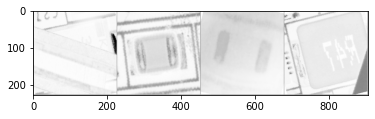

In [30]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)
print(labels)
list = labels.tolist()
for i in list:
    print(class_names[i])
    

In [31]:
print(images.size())
print(labels.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4])


In [32]:
###resnet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
##Finetuning
model_ft = models.resnet18(pretrained=True, progress=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 9)
model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [33]:
# Training Function
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            
            data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    
                    data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [35]:
model, history = train(
    model_ft,
    criterion,
    optimizer_ft,
    trainloader,
    testloader,
    save_file_name='resnet18-transfer.pt',
    max_epochs_stop=20,
    n_epochs=50,
    print_every=2)

Model has been trained for: 1 epochs.

Epoch: 1	100.00% complete. 84.19 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.1348 	Validation Loss: 0.1616
		Training Accuracy: 95.86%	 Validation Accuracy: 94.53%
Epoch: 3	100.00% complete. 87.78 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.0636 	Validation Loss: 0.0967
		Training Accuracy: 98.18%	 Validation Accuracy: 97.45%
Epoch: 5	100.00% complete. 89.66 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.0354 	Validation Loss: 0.0559
		Training Accuracy: 98.94%	 Validation Accuracy: 98.23%
Epoch: 7	99.98% complete. 79.85 seconds elapsed in epoch.Epoch: 7	100.00% complete. 79.86 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.0308 	Validation Loss: 0.0764
		Training Accuracy: 99.14%	 Validation Accuracy: 97.82%
Epoch: 9	100.00% complete. 82.57 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.0187 	Validation Loss: 0.0587
		Training Accuracy: 99.47%	 Validation Accuracy: 98.40%
Epoch: 11	100.00% complete. 79.84 secon

Text(0.5, 1.0, 'Training and Validation Losses')

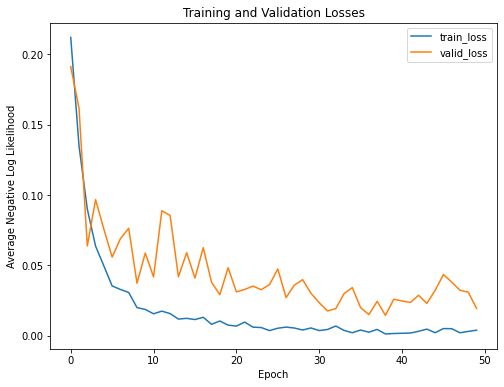

In [36]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

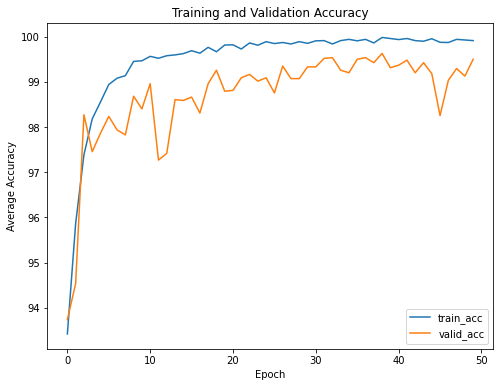

In [37]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [40]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[ 108    0    0    0    0    0    0    0    0]
 [   0 1375    0    0    0    5    0    0    0]
 [   0    0 1393    5    1    0    3    0    0]
 [   0    0    7 1400    0    0    0    0    0]
 [   0    0    0    0  169    0    0    0    0]
 [   0    0    6    0    0  762    0    0    0]
 [   0    0    0    0    0    0   99    0    0]
 [   0    0    0    0    0    0    0   14    0]
 [   0    0    0    0    0    0    0    0   32]]
[100.          99.63768116  99.35805991  99.50248756 100.
  99.21875    100.         100.         100.        ]
Confusion matrix, without normalization
[[ 108    0    0    0    0    0    0    0    0]
 [   0 1375    0    0    0    5    0    0    0]
 [   0    0 1393    5    1    0    3    0    0]
 [   0    0    7 1400    0    0    0    0    0]
 [   0    0    0    0  169    0    0    0    0]
 [   0    0    6    0    0  762    0    0    0]
 [   0    0    0    0    0    0   99    0    0]
 [   0    0    0    0    0    0    0   14    0]
 [   0    0    0    0    0    0

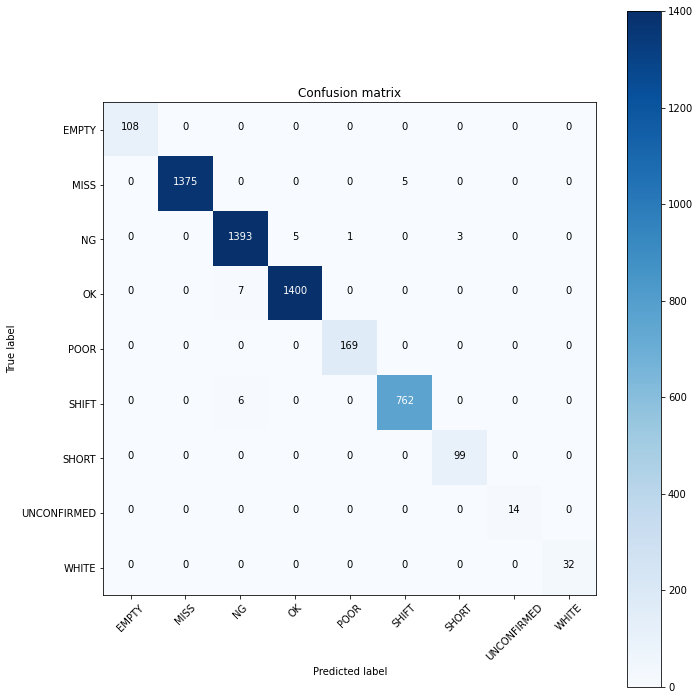

In [42]:
# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)
# Graphical analytics
cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, class_names)

Predicted:  SHIFT    NG    NG  MISS


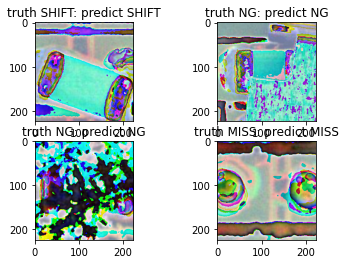

In [43]:
#make an iterator from test_loader
#Get a batch of training images
test_iterator = iter(testloader)
images, labels = test_iterator.next()
images, labels = images.cuda(), labels.cuda()

results = model_ft(images)
_, predicted = torch.max(results, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]] for j in range(4)))
rows = 2
columns = 2
fig2 = plt.figure()
fig2.tight_layout()
for i in range(4):
   fig2.add_subplot(rows, columns, i+1)
   plt.title('truth ' + class_names[labels[i]] + ': predict ' + class_names[predicted[i]])
   img = images[i] / 2 + 0.5     # this is to unnormalize the image
   img = torchvision.transforms.ToPILImage()(img.cpu())
   plt.imshow(img)
plt.show()